In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#! pip3 install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


In [2]:
data = pd.read_csv('Data/data_with_new_features.csv')
print(len(data))
data.head()

376912


,Unnamed: 0,id,time,variable,value,date,timeOfDay,year,month,day,phaseOfDay
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0,2014-02-26,13:00:00.000,2014,2,26,1
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0,2014-02-26,15:00:00.000,2014,2,26,1
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0,2014-02-26,18:00:00.000,2014,2,26,2
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0,2014-02-26,21:00:00.000,2014,2,26,2
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0,2014-02-27,09:00:00.000,2014,2,27,0


In [3]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


There are 27 users in this dataset
Tere are 19 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']
The average num of timesteps per user is 13959.7


Average mood is 6.993 with std of 1.033


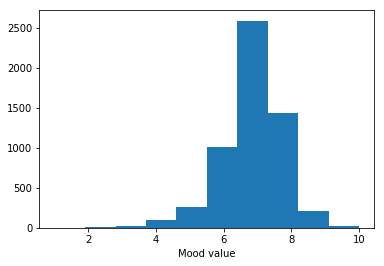

In [4]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


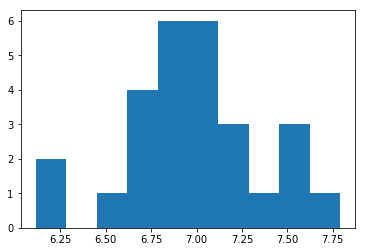

In [5]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.show()



In [6]:
#helper function to compare two dates, obsolete

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))






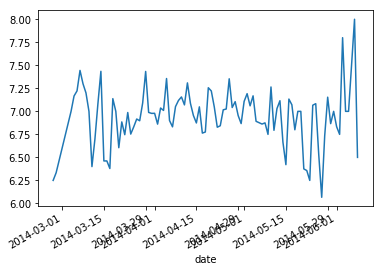

In [7]:
#getting dates and setting them as indexis
data["date"] = get_date_data_frame(data)
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['id', 'date'])

data[data['variable']=='mood']['value'].groupby(level = 'date').mean().plot()
plt.show()

Features to investigate and how to aggregate. <br />
Mood = average per day, average for t days <br /> circumplex.arousal = average<br /> circumplex.valence = average <br />
activity = average per day <br />
screen = sum per day,  average along several days, sum along days <br />
call = sum per day, average along several days, sum along days <br />
sms = sum per day, average along several days, sum along days <br />
for each in ['appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']:
 sum per day.  <br />
 
 Also days which are closer to t can be scored higher
 

In [9]:
variables = data['variable'].unique()
#generating new df
date_data = pd.DataFrame(index = data.index)
sum_variables =  [ 'screen',
 'call', 'sms' ,'appCat.builtin', 'appCat.communication',
 'appCat.entertainment', 'appCat.finance', 'appCat.game' ,'appCat.office',
 'appCat.other', 'appCat.social', 'appCat.travel' ,'appCat.unknown',
 'appCat.utilities' ,'appCat.weather']
mean_variables = ['mood', 'circumplex.arousal', 'circumplex.valence','activity']

#grouping by id and date. creating a column for value for that day with either mean or sum (described in markdown)
for variable in variables:
    if variable in sum_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].sum()#.reset_index(level=['id']).resample('D').sum()
    elif variable in mean_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].mean()#.reset_index(level=['id']).resample('D').mean()

# add temporal variables
date_data['dayofweek'] = date_data.index.get_level_values('date').dayofweek
date_data['phaseOfDay'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['phaseOfDay'].mean()#.
date_data['day'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['day'].mean()#.

# add leisure variable
date_data['leisure'] = (date_data['appCat.entertainment']+date_data['appCat.game'])

#target at day is the same as mood at day
date_data['target'] = date_data['mood']

#droping duplicates
date_data.drop_duplicates( keep='first', inplace=True)

#filling missing values were NaN means 0
values0 = {key: 0 for key in sum_variables}
values0['leisure'] = 0

date_data.fillna(value=values0, inplace=True)
#to do : think about values he didn't fill yet. although we have xgboost, so shouldn't be a problem

In [10]:
# get information about new features
date_data.corr(method='pearson')

,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,...,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,dayofweek,phaseOfDay,day,leisure,target
mood,1.000000,0.152953,0.685227,0.167145,0.044116,0.027335,-0.042579,0.014357,0.052336,0.088920,...,-0.050132,0.024133,0.030130,0.041552,0.018164,0.096071,-0.021719,-0.040271,0.120285,1.000000
circumplex.arousal,0.152953,1.000000,0.169303,-0.003677,-0.177627,0.029984,0.021017,0.035559,-0.168798,-0.084420,...,-0.096554,-0.013136,-0.033673,-0.005847,0.028972,-0.027664,-0.094643,-0.001530,-0.096278,0.152953
circumplex.valence,0.685227,0.169303,1.000000,0.166394,0.012121,-0.071912,-0.069372,-0.027080,0.058117,0.060626,...,-0.072159,0.019965,0.068940,0.053145,-0.056704,0.089779,-0.045166,0.013440,0.097554,0.685227
activity,0.167145,-0.003677,0.166394,1.000000,0.238639,0.142452,0.062664,0.067318,0.263075,0.053474,...,-0.040604,0.125052,0.084462,-0.030539,-0.050464,0.072627,0.009687,0.019928,0.151878,0.167145
screen,0.044116,-0.177627,0.012121,0.238639,1.000000,-0.063637,-0.075142,0.190410,0.756619,0.392958,...,0.535384,0.128295,0.148337,0.242821,0.157199,-0.046587,-0.031114,0.058477,0.328285,0.044116
call,0.027335,0.029984,-0.071912,0.142452,-0.063637,1.000000,0.099309,0.009662,-0.079626,-0.067677,...,-0.078864,0.023648,-0.087867,-0.047245,-0.041812,-0.023776,0.077963,0.043217,-0.085313,0.027335
sms,-0.042579,0.021017,-0.069372,0.062664,-0.075142,0.099309,1.000000,-0.028468,-0.069155,-0.064404,...,-0.043453,0.020836,-0.031840,-0.055361,-0.052580,-0.020947,0.012687,0.012835,-0.048631,-0.042579
appCat.builtin,0.014357,0.035559,-0.027080,0.067318,0.190410,0.009662,-0.028468,1.000000,0.057744,0.064267,...,0.130491,0.034110,0.011902,0.056554,0.087951,0.031552,0.004085,-0.011801,0.062770,0.014357
appCat.communication,0.052336,-0.168798,0.058117,0.263075,0.756619,-0.079626,-0.069155,0.057744,1.000000,0.266098,...,0.232514,0.063335,0.130065,0.139572,0.074172,-0.075071,-0.011664,0.064585,0.200964,0.052336
appCat.entertainment,0.088920,-0.084420,0.060626,0.053474,0.392958,-0.067677,-0.064404,0.064267,0.266098,1.000000,...,0.100249,0.062858,0.099121,0.047851,0.044554,0.011686,-0.006249,0.033470,0.282745,0.088920


In [11]:
#rolling mean
lag = 10
rolling_variables  = date_data.columns
#for lag in range(1,max_lag):
for variable in rolling_variables:
    date_data["{}_lagged_by_{}".format(variable, lag)]=date_data[variable].rolling(window = lag).mean()

In [12]:
date_data.corr(method='pearson')['target_lagged_by_10']

mood                                 0.574100
circumplex.arousal                   0.069797
circumplex.valence                   0.249022
activity                             0.132006
screen                               0.132606
call                                 0.014463
sms                                 -0.057496
appCat.builtin                       0.057017
appCat.communication                 0.105988
appCat.entertainment                 0.134648
appCat.finance                       0.079218
appCat.game                          0.081795
appCat.office                        0.094345
appCat.other                         0.092459
appCat.social                       -0.007041
appCat.travel                        0.017228
appCat.unknown                       0.017912
appCat.utilities                     0.026094
appCat.weather                       0.063885
dayofweek                            0.006324
phaseOfDay                          -0.100486
day                               

In [13]:
#creating variables to drop
#BUG SLIDE TO T-1
list_var = list(rolling_variables)
list_var.remove('target')
#fill target   MSE: 0.2652, don't think it's valid
#date_data['target'].fillna(method = "ffill", inplace=1)

# drop nan target MSE: 0.3179
#133 nan targets

date_data.dropna(axis = 0,subset = ["target"], inplace=True)


feature_data = np.array(date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var))
x, y =feature_data[:-1,1:], feature_data[1:,0]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [14]:
y_pred = model.predict(X_test)

#print(y_test, predictions)
accuracy = mean_squared_error(y_test, y_pred)
print("MSE: {:.4}" .format(accuracy))
print(X_test.shape)

MSE: 0.3466
(419, 24)


In [15]:
#baseline  MSE: 0.5868
baseline_vector = []
for i, m in enumerate(date_data['mood']):
    if i==0:
        continue
    baseline_vector.append(date_data['mood'].iloc[i-1])

x, y =np.array(baseline_vector).reshape(-1,1) , np.array(date_data['mood']).reshape(-1,1)

accuracy = mean_squared_error(y[1:], x)
print("MSE: {:.4}" .format(accuracy))

MSE: 0.5819
